In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Document embedding:
## Bag of Words / tf-idf
## Sum / Mean of word embeddings
## Doc2Vec
## BERT

# Document distance:
## Euclidean / Cosine distance
## Word Movers' Distance

In [3]:
train_docs = catalog.load('train_docs')
train_corpus = catalog.load('train_corpus')
val_docs = catalog.load('val_docs')
val_corpus = catalog.load('val_corpus')
dictionary = catalog.load('dictionary')

2020-04-03 13:21:51,577 - kedro.io.data_catalog - INFO - Loading data from `train_docs` (PickleLocalDataSet)...
2020-04-03 13:21:51,774 - kedro.io.data_catalog - INFO - Loading data from `train_corpus` (MmCorpusDataSet)...
2020-04-03 13:21:51,776 - gensim.corpora.indexedcorpus - INFO - loaded corpus index from data/05_model_input/train_corpus.mm.index
2020-04-03 13:21:51,778 - gensim.corpora._mmreader - INFO - initializing cython corpus reader from data/05_model_input/train_corpus.mm
2020-04-03 13:21:51,779 - gensim.corpora._mmreader - INFO - accepted corpus with 15078 documents, 2715 features, 1054084 non-zero entries
2020-04-03 13:21:51,780 - kedro.io.data_catalog - INFO - Loading data from `val_docs` (PickleLocalDataSet)...
2020-04-03 13:21:51,831 - kedro.io.data_catalog - INFO - Loading data from `val_corpus` (MmCorpusDataSet)...
2020-04-03 13:21:51,833 - gensim.corpora.indexedcorpus - INFO - loaded corpus index from data/05_model_input/val_corpus.mm.index
2020-04-03 13:21:51,833 -

## Bag of Words / tf-idf

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [5]:
tmp = [' '.join(doc) for doc in train_docs]
pipe = Pipeline([('count', CountVectorizer(vocabulary=list(dictionary.token2id))),
                 ('tfid', TfidfTransformer())]).fit(tmp)

In [26]:
train_bow = pipe['count'].transform(tmp).toarray()
train_bow = train_bow / train_bow.sum(axis=1, keepdims=True)
train_tfidf = pipe.transform(tmp).toarray()

## Sum / Mean of word embeddings

In [60]:
dict = catalog.load('dict_embeddings_norm')

2020-04-03 13:37:55,332 - kedro.io.data_catalog - INFO - Loading data from `dict_embeddings_norm` (PickleLocalDataSet)...


In [79]:
train_concat_emb = []
for doc in train_docs:
    doc_emb = []
    for w in doc:
        if w in dict:
            doc_emb.append(dict[w])
    doc_emb = np.array(doc_emb)
    #train_concat_emb.append(doc_emb.sum(axis=0))
    train_concat_emb.append(doc_emb.mean(axis=0))
train_concat_emb = np.array(train_concat_emb)

## Doc2Vec

## Clustering

In [80]:
corpus = train_concat_emb

In [81]:
from sklearn.cluster import KMeans

num_topics = 15
model = KMeans(n_clusters=num_topics).fit(corpus)

In [82]:
from sklearn.preprocessing import OneHotEncoder

vocab_size = len(dictionary)

preds = model.predict(corpus)
preds = preds.reshape((-1, 1))
enc = OneHotEncoder(handle_unknown='ignore').fit(preds)
theta = enc.transform(preds).toarray()

In [83]:
beta = np.zeros((num_topics, vocab_size))
for i,doc in enumerate(train_docs):
    topic_id = preds[i][0]
    for w in doc:
        beta[topic_id][dictionary.token2id[w]] += 1
beta = beta / beta.sum(axis=1, keepdims=True)

## Eval model

In [84]:
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import MDS

def extract_top_n_words(topic_distributions, dictionary, topic_id, top_n):
    top_n_words = [dictionary[np.argsort(topic_distributions[topic_id])[-i-1]] for i in range(top_n)]
    top_n_freqs = [np.sort(topic_distributions[topic_id])[-i-1] for i in range(top_n)]
    return top_n_words, top_n_freqs

def calculate_topic_distances(topic_distributions):
    num_topics = len(topic_distributions)
    distances = np.zeros((num_topics, num_topics))
    for i in range(num_topics):
        for j in range(num_topics):
            topic_i, topic_j = topic_distributions[i], topic_distributions[j]
            distances[i][j] = jensenshannon(topic_i, topic_j)
    return distances

def show_most_m_represantative_docs(doc_topic, m, docs, topic_id):
    indices_max = np.argsort(doc_topic[:,topic_id])[-m:]
    verbatims = []
    for idx in reversed(indices_max):
        doc = docs[idx]
        verbatims.append(' '.join(list(doc)))
    return verbatims

def occ_dict(doc):
    occurences_dict = {}
    for word in doc:
        if word in occurences_dict:
            occurences_dict[word] += 1
        else:
            occurences_dict[word] = 1
    return occurences_dict

def get_Dwi(wi, doc_dicts):
    Dwi = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict:
            Dwi += doc_dict[wi]
    return Dwi

def get_Dwiwj(wi, wj, doc_dicts):
    Dwiwj = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict and wj in doc_dict:
            Dwiwj += doc_dict[wi] * doc_dict[wj]
    return Dwiwj

def topic_coherence(topic_distributions, dictionary, topic_id, top_n, docs, method='umass', eps=1e-5):
    top_words, _ = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n)

    N = top_n - 1

    D = 0
    for doc in docs:
        D += len(doc)
    #D = len(docs)

    # remplacer par un CountVectorizer
    doc_dicts = [occ_dict(doc) for doc in docs]

    score = 0.
    for i in range(1, N):
        for j in range(i):
            wi = top_words[i]
            wj = top_words[j]

            Dwj = get_Dwi(wj, doc_dicts)
            Dwiwj = get_Dwiwj(wi, wj, doc_dicts)

            pwj = Dwj / D
            pwiwj = Dwiwj / D

            # umass
            if method == 'umass':
                score += np.log((pwiwj + eps) / pwj)

            # pmi
            elif method == 'pmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D
                score += np.log((pwiwj + eps) / (pwi * pwj))

            # npmi
            elif method == 'npmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D

                if Dwiwj == 0:
                    score += -1.
                elif Dwiwj == Dwi and Dwiwj == Dwj:
                    score += 1.
                else:
                    score += np.log((pwiwj + eps) / (pwi * pwj)) / (- np.log(pwiwj + eps))

    return score / (2 * N * (N - 1))

def topic_diversity(topic_distributions, dictionary, top_n):
    top_words = []
    num_topics = len(topic_distributions)
    for k in range(num_topics):
        tmp, _ = extract_top_n_words(topic_distributions, dictionary, k, top_n)
        top_words += tmp
    return len(np.unique(top_words)) / len(top_words)

def eval_model(topic_distributions, doc_topic_matrix, dictionary, train_docs,
               num_topics, top_n_show=10, m_most=1, top_n_coherence=10, top_n_diversity=25):

    # Metrics

    ## Qualitative Metrics

    ### Top-n words per topic
    for topic_id in range(num_topics):
        top_n_words, top_n_freqs = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n_show)

        plt.figure(figsize=(10, 4))
        plt.title('Topic number ' + str(topic_id))
        plt.bar(top_n_words, top_n_freqs)
        plt.show()

    ### Topic sizes
    #

    ### Topic distances
    distances = calculate_topic_distances(topic_distributions)
    plt.figure(figsize=(6, 6))
    plt.imshow(distances, cmap='Greys')
    plt.show()

    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(distances).embedding_
    plt.figure(figsize=(6, 6))
    plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0)
    plt.show()

    ### Most m representative documents
    for topic_id in range(num_topics):
        print('Topic number ', topic_id, show_most_m_represantative_docs(doc_topic_matrix, m_most, train_docs, topic_id))


    ## Quantitative Metrics

    ### Topic Coherence
    mean_tc = 0.
    for topic_id in range(num_topics):
        tc = topic_coherence(topic_distributions, dictionary, topic_id, top_n_coherence, train_docs, method='npmi')
        print('Topic number ', topic_id, 'tc:', tc)
        mean_tc += tc
    print('Topic coherence:', mean_tc / num_topics)

    ### Topic Diversity
    print('Topic diversity', topic_diversity(topic_distributions, dictionary, top_n_diversity))

    ### Predictive Quality
    #

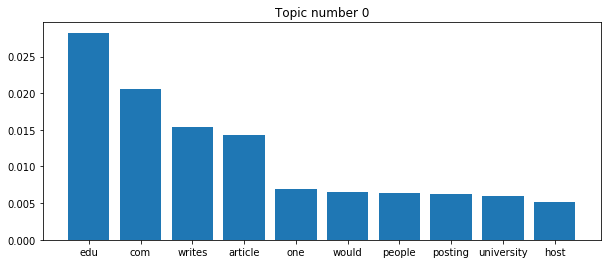

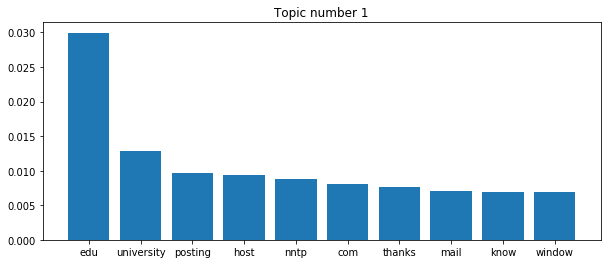

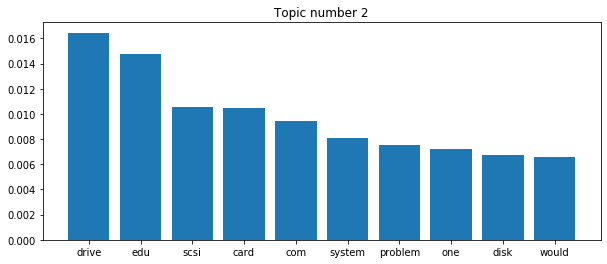

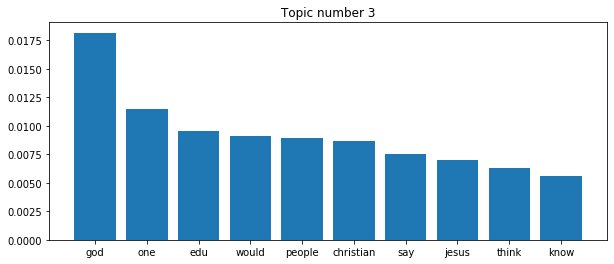

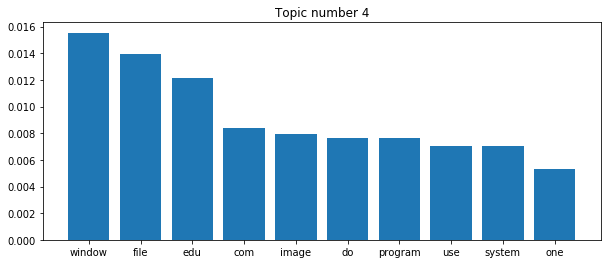

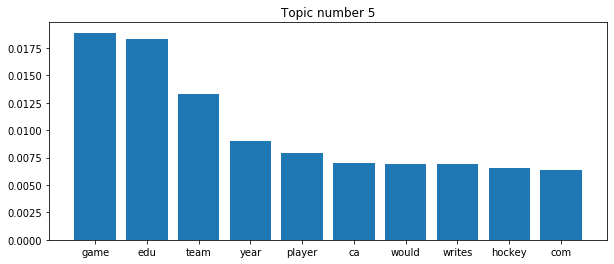

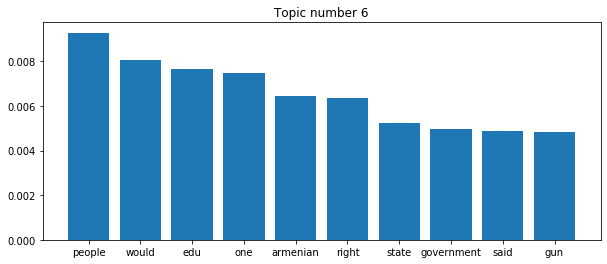

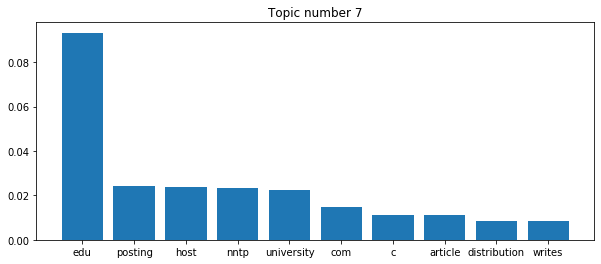

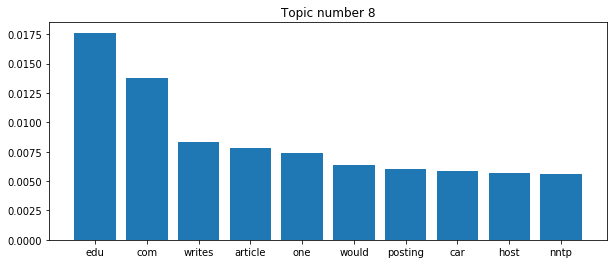

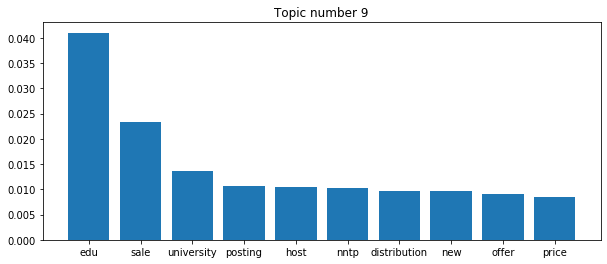

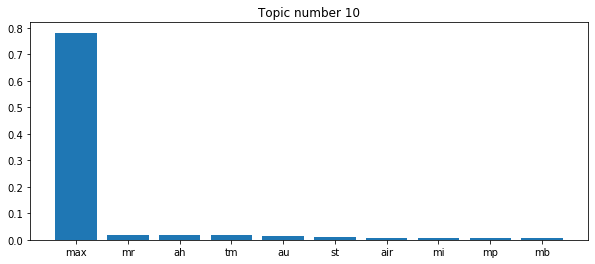

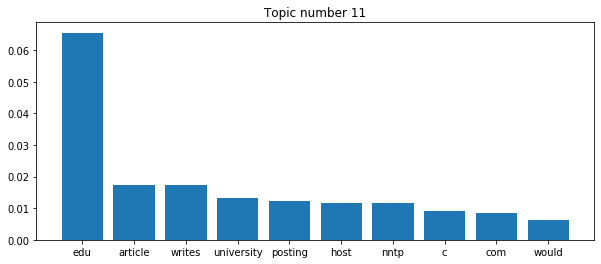

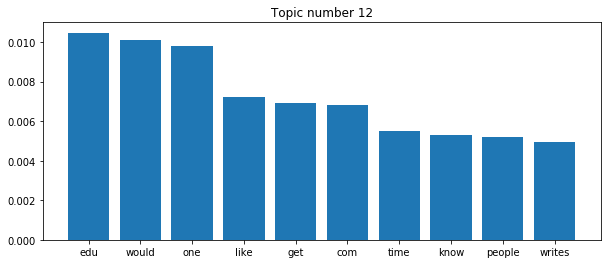

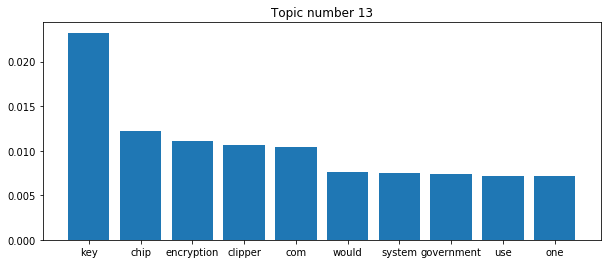

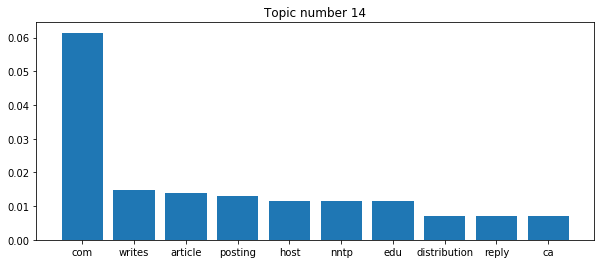

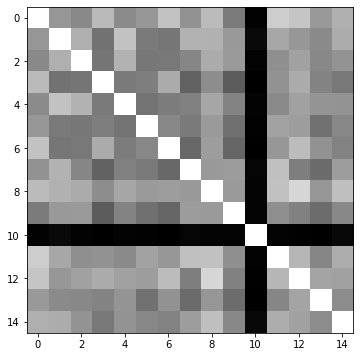

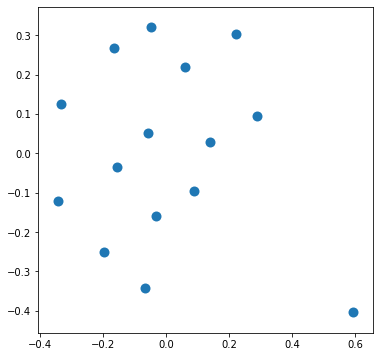

Topic number  0 ['ac steve question mary university south article may athos rutgers edu andrew cmu edu andrew writes noted also hold belief part even though broke away ad council might catholic made belief put big hole notion also hold belief split belief first writing far known much lost time father belief church false belief often held council political factor thus led way steve department department univ south box south internet ac fidonet steve fidonet org faq study christian mission part']
Topic number  1 ['edu paul cd rom index available california state university nntp posting host edu file content knowledge medium resource library graphic knowledge medium resource library audio available anonymous ftp com']
Topic number  2 ['wisc edu fast do vga window video card info needed college engineering univ wisconsin ok isa diamond really performance window game need higher frame rate do vga especially new strike give use million think right considering replace new card hopefully perfo

Topic number  0 tc: 0.27210541896870516
Topic number  1 tc: 0.22904411149094545
Topic number  2 tc: 0.3005616477842554
Topic number  3 tc: 0.31575186120490184
Topic number  4 tc: 0.39830348007587973
Topic number  5 tc: 0.26889442251089474
Topic number  6 tc: 0.31320559291907113
Topic number  7 tc: 0.2372026192259572
Topic number  8 tc: 0.2540258751002944
Topic number  9 tc: 0.21238353475287383
Topic number  10 tc: 0.3416963789955867
Topic number  11 tc: 0.2441513662888109
Topic number  12 tc: 0.31979080762650175
Topic number  13 tc: 0.2795344645011879
Topic number  14 tc: 0.23333343440407386
Topic coherence: 0.281332334389996
Topic diversity 0.44533333333333336


In [85]:
eval_model(beta, theta, dictionary, train_docs, num_topics, 
           top_n_show=10, m_most=1, top_n_coherence=10, top_n_diversity=25)